# Inverted Indexes and Searching

In [16]:
from nltk.corpus import brown
import re

## Building an Inverted Index

We start off with a collection of documents. These have already been tokenized into words for us.

In [137]:
docs = list(brown.files())[:500]
texts = [None]*len(docs)
for i,doc in enumerate(docs):
    with brown.open(doc) as stream:
        texts[i] = brown.words(fileids=[doc])

Next, we apply linguistic preprocessing in order to remove variations that are of no interest to retrieval. We already talked about more sophisticated methods when we talked about stemming.

In [138]:
for i,t in enumerate(texts):
    texts[i] = [re.sub('(s|ing)$','',w.lower()) for w in t]

Now we build a dictionary: a sorted list of unique tokens, together with a way of mapping tokens to integers.

In [139]:
dictionary = sorted(list(set([w for t in texts for w in t])))
print len(dictionary),dictionary[:3],dictionary[-3:]

43259 ['', '!', '$.027'] ['zwei', 'zworykin', '{0,t}']


In [140]:
wids = {w:i for i,w in enumerate(dictionary)}
wids["find"]

15435

Given the dictionary, we now add each document to the set of postings for each of the terms contained in the document.

In [141]:
psets = [set() for w in dictionary]
for d,text in enumerate(texts):
    for w in text:
        psets[wids[w]].add(d)

The inverted index is the sorted list of postings for each token in the dictionary.

(Of course, in practice, we wouldn't use the `set` data structure and then create the list
out of it, we'd likely use the inverted index data structure itself during the building.)

In [144]:
invindex = [sorted(list(s)) for s in psets]
wid = wids["find"]
print wid
print invindex[wid]
print dictionary[wid]

15435
[0, 3, 5, 7, 8, 20, 21, 23, 25, 26, 27, 29, 31, 33, 40, 42, 43, 45, 47, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 65, 66, 68, 69, 70, 71, 73, 75, 76, 77, 83, 85, 87, 88, 90, 91, 92, 94, 95, 96, 98, 99, 100, 102, 104, 105, 106, 107, 108, 110, 111, 114, 116, 118, 121, 123, 124, 125, 126, 127, 128, 130, 132, 134, 135, 136, 137, 139, 140, 143, 144, 145, 146, 147, 148, 152, 153, 154, 156, 158, 162, 163, 164, 166, 169, 170, 171, 173, 175, 178, 179, 180, 181, 182, 183, 185, 186, 187, 189, 193, 197, 200, 201, 202, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 224, 225, 226, 228, 230, 231, 232, 234, 235, 238, 239, 240, 242, 243, 244, 245, 248, 249, 250, 252, 255, 256, 257, 258, 262, 263, 269, 272, 275, 278, 279, 280, 281, 282, 287, 288, 293, 297, 301, 303, 305, 307, 311, 312, 313, 315, 317, 320, 322, 323, 324, 327, 328, 329, 331, 334, 335, 336, 339, 340, 343, 344, 345, 346, 347, 348, 350, 351, 353, 354, 356, 359, 362, 366, 367, 372, 375, 376, 377, 378, 380,

# Compression

Inverted indexes can be compressed greatly by taking advantage of their statistics.

For example, by default, the set of document indexes just forms a fairly uniform distribution over the range of term indexes.

(array([20, 32, 33, 26, 36, 21, 28, 26, 34, 30]),
 array([   0. ,   49.8,   99.6,  149.4,  199.2,  249. ,  298.8,  348.6,
        398.4,  448.2,  498. ]),
 <a list of 10 Patch objects>)

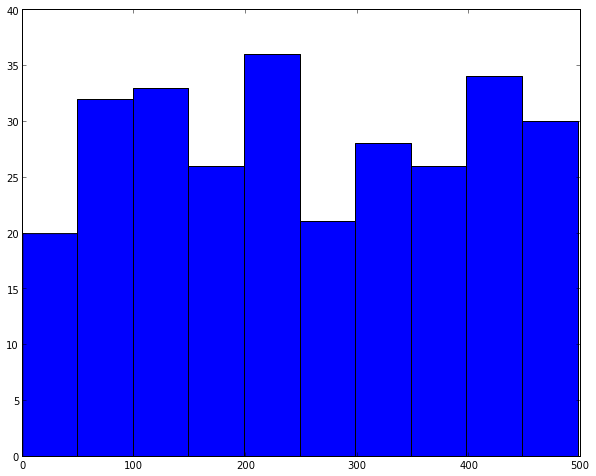

In [149]:
l = [0]+invindex[wid]
hist(l)

But if the document ids have been assigned randomly, their deltas are Poisson distributed, and we get a distribution that compresses much better than the uniform distribution.

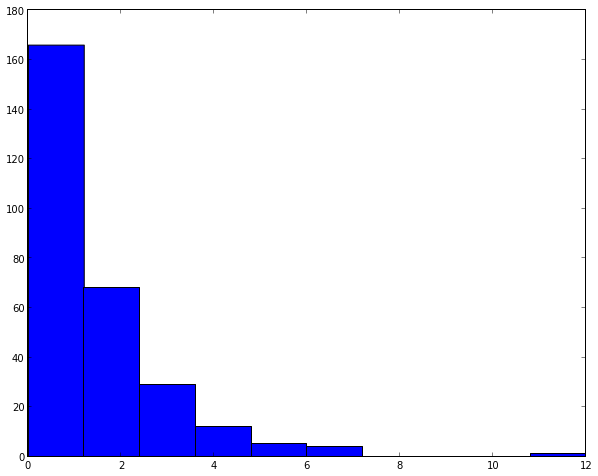

In [150]:
deltas = [l[i]-l[i-1] for i in range(1,len(l))]
_=hist(deltas)

There are other forms of compression that we can use.  For example, the dictionary terms (as strings) are sorted and can be represented in a Trie, analogous to prefix compression in B-trees.

Tricks like these are important for improving the practical performance of information retrieval systems.

However, often, you may be better off using a general purpose solution instead of a special purpose solution. E.g., the problem of representing lists of integers compactly has (implicitly) found attention in other areas of computer science, and you may be able to just reuse those results.

## Matrix View

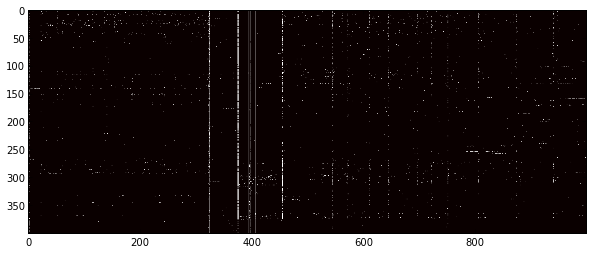

In [135]:
tdmatrix = zeros((1000,400))
for tid in range(1000):
    for did in invindex[tid]:
        if did>=400: break
        tdmatrix[tid,did] = 1
figsize(10,8)
imshow(tdmatrix.T,cmap=cm.hot)
        

## Queries

In terms of this inverted index, we can now express queries as intersections and unions of sorted lists of postings.

In [58]:
def intersect_postings(u,v):
    # u and v must be sorted
    result = []
    while u!=[] and v!=[]:
        if u[0]==v[0]: 
            result.append(u[0])
            u = u[1:]
            v = v[1:]
        elif u[0]<v[0]: 
            u = u[1:]
        else: 
            v = v[1:]
    return result

In [59]:
intersect_postings(invindex[wids["find"]],invindex[wids["county"]])

[0, 5, 8, 20, 21, 25, 43, 45, 47, 51, 54, 55, 57, 58, 60, 71, 85]

Note that in Python, we could just have intersected the sets directly.

In [62]:
psets[wids["find"]].intersection(psets[wids["county"]])

set([0, 5, 71, 8, 57, 43, 45, 47, 51, 20, 21, 54, 55, 25, 58, 60, 85])

In [63]:
sorted(list(psets[wids["find"]].intersection(psets[wids["county"]])))

[0, 5, 8, 20, 21, 25, 43, 45, 47, 51, 54, 55, 57, 58, 60, 71, 85]

Think about how the efficiency of the built-in Python type compares to the inverted index. What is happening internally?

## Building Very Large Indexes

The above method of constructing the inverted index puts everything into memory.
Often, that doesn't work very well because there are many more documents than would fit
into memory.

You could write special purpose code to deal with this case, but it turns out
that building inverted indexes can already be handled efficiently with existing tools,
requiring only sequential processing.

In [66]:
brown.abspath("ca01")

FileSystemPathPointer('/home/tmb/nltk_data/corpora/brown/ca01')

We use `grep` for the tokenization (we could also perform linguistic preprocessing on these tokens).
That generates a list of files and corresponding tokens.
This is a purely sequential process (very little memory).

In [88]:
!egrep -o '[a-zA-Z]+' /home/tmb/nltk_data/corpora/state_union/* > occurrences
!head occurrences

/home/tmb/nltk_data/corpora/state_union/1945-Truman.txt:PRESIDENT
/home/tmb/nltk_data/corpora/state_union/1945-Truman.txt:HARRY
/home/tmb/nltk_data/corpora/state_union/1945-Truman.txt:S
/home/tmb/nltk_data/corpora/state_union/1945-Truman.txt:TRUMAN
/home/tmb/nltk_data/corpora/state_union/1945-Truman.txt:S
/home/tmb/nltk_data/corpora/state_union/1945-Truman.txt:ADDRESS
/home/tmb/nltk_data/corpora/state_union/1945-Truman.txt:BEFORE
/home/tmb/nltk_data/corpora/state_union/1945-Truman.txt:A
/home/tmb/nltk_data/corpora/state_union/1945-Truman.txt:JOINT
/home/tmb/nltk_data/corpora/state_union/1945-Truman.txt:SESSION


Next, we sort on the document name and then assign document ids.
The sorting process is potentially expensive and may use a lot of memory,
but this is handled efficiently by the merge sort algorithm inside `sort`.

We also use the `-u` (unique) argument because we are only interested in a single
correspondence per document.

We assign document ids by watching when the document name changes in the sorted list.

In [112]:
!sort -u occurrences | awk 'BEGIN{FS=":"};{if($1!=last){did++;last=$1};print did,$2}' > did-token
!head did-token

1 A
1 ADDRESS
1 Admiral
1 Aggressors
1 All
1 Allies
1 Almighty
1 America
1 American
1 Americans


The `sort` program lets us sort on arbitrary keys, so we now sort on the token as keys.

In [113]:
!sort -k 2,2 -k 1,1n did-token > bytoken
!head bytoken

1 A
2 A
3 A
4 A
5 A
6 A
8 A
9 A
10 A
11 A


Finally, we repeat the process of assigning ids to tokens sequentially,
and we also invert the order.
This now gives us a representation of the inverted index that we can read in directly.

In [114]:
!awk '{if($2!=last){wid++;last=$2};print wid,$1}' bytoken > invindex
!head invindex

1 1
1 2
1 3
1 4
1 5
1 6
1 8
1 9
1 10
1 11


We can now read in the inverted index very easily (but, of course, if the whole
inverted index fit into memory, we could have just built it directly).

In [115]:
invindex = [[] for i in range(20000)]
for l in open("invindex").readlines():
    wid,tid = [int(s) for s in l.split()]
    invindex[wid].append(tid)

In [116]:
invindex[700]

[2, 11, 13, 16, 17, 21, 23, 24, 25, 38, 57, 58]

Of course, we would have to keep track of the string-to-id assignments (these can just be logged to a file).


Again, what makes this work efficiently is the fact that we have reduced all the operations to...

- sequential operations that use constant memory (`grep`, id assignment)
- text file sorting, which uses highly optimized algorithms for disk/memory sorting

If you're building large inverted indexes for research purposes, this is a good way of doing it.
It is similar in spirit to `MapReduce` (and can be run distributed by using distributed sorting etc.).


Note that you don't get a *dynamic index*: if you have to insert a large number of new documents,
you need to restart the process.